In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))


# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
pip install nibabel

Note: you may need to restart the kernel to use updated packages.


In [3]:
import nibabel as nib
import glob
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from tifffile import imsave
import random

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [5]:
path = '../input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/'

### Load Data

In [6]:
data_t1ce = nib.load(path + 'BraTS20_Training_069/BraTS20_Training_069_t1ce.nii').get_fdata()
data_t1ce = minmax.fit_transform(data_t1ce.reshape(-1,data_t1ce.shape[-1])).reshape(data_t1ce.shape)
data_t1ce.shape

(240, 240, 155)

In [7]:
data_t2 = nib.load(path + 'BraTS20_Training_069/BraTS20_Training_069_t2.nii').get_fdata()
data_t2 = minmax.fit_transform(data_t2.reshape(-1,data_t2.shape[-1])).reshape(data_t2.shape)

In [8]:
data_flair = nib.load(path + 'BraTS20_Training_069/BraTS20_Training_069_flair.nii').get_fdata()
data_flair = minmax.fit_transform(data_flair.reshape(-1,data_flair.shape[-1])).reshape(data_flair.shape)

In [9]:
data_mask = nib.load(path + 'BraTS20_Training_069/BraTS20_Training_069_seg.nii').get_fdata()
data_mask=data_mask.astype(np.uint8)

In [10]:
import random
n=random.randint(0, data_mask.shape[2])

In [11]:
# Combining 3 different images to a single channel - to explore more
comb = np.stack([data_flair, data_t1ce,data_t2], axis=3)
comb=comb[56:184, 56:184, 13:141] #Crop to 128x128x128x4
#mask_data
data_mask = data_mask[56:184, 56:184, 13:141]

#### Visualizing the data

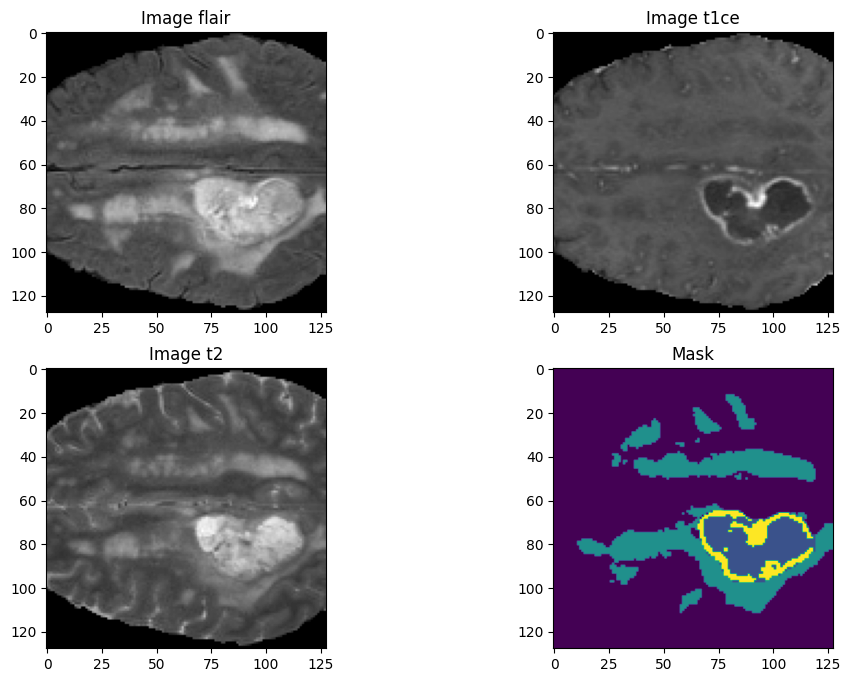

In [13]:
n_slice=random.randint(0, data_mask.shape[2])
plt.figure(figsize=(12, 8))

plt.subplot(221)
plt.imshow(comb[:,:,n_slice, 0], cmap='gray')
plt.title('Image flair')
plt.subplot(222)
plt.imshow(comb[:,:,n_slice, 1], cmap='gray')
plt.title('Image t1ce')
plt.subplot(223)
plt.imshow(comb[:,:,n_slice, 2], cmap='gray')
plt.title('Image t2')
plt.subplot(224)
plt.imshow(data_mask[:,:,n_slice])
plt.title('Mask')
plt.show()

In [14]:
#importing datasets and getting ready

In [15]:
t2_list = sorted(glob.glob('../input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/*/*t2.nii'))
t1ce_list = sorted(glob.glob('../input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/*/*t1ce.nii'))
flair_list = sorted(glob.glob('../input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/*/*flair.nii'))
mask_list = sorted(glob.glob('../input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/*/*seg.nii'))

#### Data preprocessing

In [38]:
import skimage.transform as skTrans
for img in range(100):
    data_flair = nib.load(flair_list[img]).get_fdata()
    data_flair = skTrans.resize(data_flair,(64,64,64),preserve_range=True)
    data_mask = nib.load(mask_list[img]).get_fdata()
    data_mask = skTrans.resize(data_mask,(64,64,64),preserve_range=True)
    if img==0:
        xtrain = data_flair.reshape((1,64,64,64))
        ytrain = data_mask.reshape((1,64,64,64))
    else:
        xtrain = np.vstack((xtrain,data_flair.reshape((1,64,64,64))))
        ytrain = np.vstack((ytrain,data_mask.reshape((1,64,64,64))))

In [20]:
print(xtrain.shape,ytrain.shape)
print(len(xtrain))

(100, 64, 64, 64) (100, 64, 64, 64)
100


#### Train Test split

In [39]:
x_train,x_test = xtrain[:70],xtrain[70:]
y_train,y_test = ytrain[:70],ytrain[70:]

### Base Model - 3D UNet

In [23]:
import tensorflow as tf
from tensorflow import keras

#### Function for convolution block

In [24]:
def conv_block(inp,filters):
    c1 = keras.layers.Conv3D(filters,kernel_size=3,padding="same",activation="relu")(inp)
    c2 = keras.layers.Conv3D(filters,kernel_size=3,padding="same",activation="relu")(c1)
    
    return c2

#### Function for encoder block

In [25]:
def encoder_block(inp,filters):
    # Consists of the convolution block followed by max pooling
    c = conv_block(inp,filters)
    p = keras.layers.MaxPooling3D(pool_size=(2,2,2))(c)
    
    return c,p

#### Function for decoder block

In [26]:
def decoder_block(inp,skip_features,filters):
    #Upsampling to increase the dimension
    u1 = keras.layers.UpSampling3D(size=(2,2,2))(inp)
    # Concatenating the skip connection with upsampled layer
    skip = keras.layers.Concatenate()([u1,skip_features])
    # Performing convolution operation
    c = conv_block(skip,filters)
    
    return c 

#### U-Net Architecture

In [27]:
# Building the model
inp = keras.Input(shape=(64,64,64,1))

# Encoder block 1
c1,p1 = encoder_block(inp,64)
# Encoder block 2
c2,p2 = encoder_block(p1,128)
# Encoder block 3
c3,p3 = encoder_block(p2,256)
# Encoder block 4
c4,p4 = encoder_block(p3,512)

# Bottleneck layer - gives compressed representation of the raw image
b = conv_block(p4,1024)

# Decoder block 1
d1 = decoder_block(b,c4,512)
# Decoder block 2
d2 = decoder_block(d1,c3,256)
# Decoder block 3
d3 = decoder_block(d2,c2,128)
#Decoder block 4
d4 = decoder_block(d3,c1,64)

# Output layer
out = keras.layers.Conv3D(1,kernel_size=1,padding="same",activation="relu")(d4)

In [28]:
model = keras.Model(inp,out,name="U-Net")
model.summary()

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 64,  0           []                               
                                 1)]                                                              
                                                                                                  
 conv3d (Conv3D)                (None, 64, 64, 64,   1792        ['input_1[0][0]']                
                                64)                                                               
                                                                                                  
 conv3d_1 (Conv3D)              (None, 64, 64, 64,   110656      ['conv3d[0][0]']                 
                                64)                                                           

### Training the Model 

In [29]:
 pip install segmentation-models-3D

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.5/69.5 kB 9.0 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


#### Setting the optimizer & loss

In [30]:
import segmentation_models_3D as sm
# Defining the loss function, optimizer& metrics to be used for training
dice_loss = sm.losses.DiceLoss(class_weights=np.array([0.25,0.25,0.25,0.25]))
lr = 0.0001
# Also try using Adam as an optimizer
optim = keras.optimizers.SGD(learning_rate=lr,momentum=0.35)

Segmentation Models: using `tf.keras` framework.


In [31]:
# Fitting the model
model.compile(optimizer=optim,loss=dice_loss,metrics=['accuracy'])

#### Fitting the model

In [40]:
hist = model.fit(x_train,y_train,batch_size=8,epochs=5,validation_data=(x_test,y_test))

Epoch 1/5
9/9 [==============================] - 45s 5s/step - loss: 0.8763 - accuracy: 0.8248 - val_loss: 0.8823 - val_accuracy: 0.8560
Epoch 2/5
9/9 [==============================] - 43s 5s/step - loss: 0.8588 - accuracy: 0.8775 - val_loss: 0.8677 - val_accuracy: 0.9070
Epoch 3/5
9/9 [==============================] - 43s 5s/step - loss: 0.8409 - accuracy: 0.9040 - val_loss: 0.8497 - val_accuracy: 0.9217
Epoch 4/5
9/9 [==============================] - 43s 5s/step - loss: 0.8188 - accuracy: 0.9195 - val_loss: 0.8291 - val_accuracy: 0.9283
Epoch 5/5
9/9 [==============================] - 43s 5s/step - loss: 0.7977 - accuracy: 0.9314 - val_loss: 0.8091 - val_accuracy: 0.9294


#### Inferences from training the base model

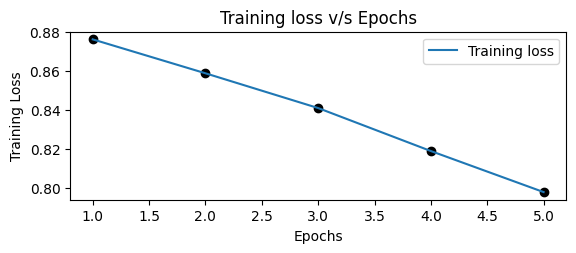

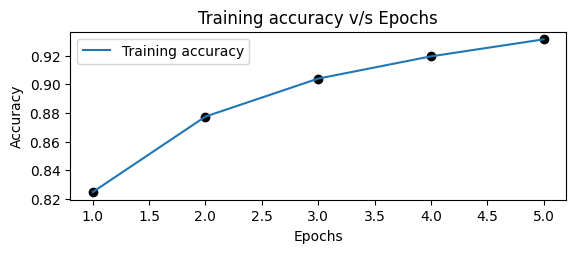

<Figure size 640x480 with 0 Axes>

In [41]:
import matplotlib.pyplot as plt

plt.subplot(2,1,1)
train_loss = hist.history['loss']
epochs = range(1,len(train_loss)+1)
plt.plot(epochs,train_loss,label="Training loss")
plt.scatter(epochs,train_loss,color="black")
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.title('Training loss v/s Epochs')
plt.legend()
plt.show()


plt.subplot(2,1,2)
train_acc = hist.history['accuracy']
epochs = range(1,len(train_acc)+1)
plt.plot(epochs,train_acc,label="Training accuracy")
plt.scatter(epochs,train_acc,color="black")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training accuracy v/s Epochs')
plt.legend()
plt.show()

plt.subplots_adjust(top=7,right=2.5,bottom=5)

In [43]:
prediction = model.evaluate(x_test,y_test,batch_size=8)

4/4 [==============================] - 5s 1s/step - loss: 0.8091 - accuracy: 0.9294


#### Test Results

In [46]:
print('Loss obtained :',round(prediction[0],2),'\nAccuracy obtained :',round(prediction[1],2))

Loss obtained : 0.81 
Accuracy obtained : 0.93


### Refinement Model - Attention 3D-UNet

#### Defining the attention block

In [100]:
def attention_gate(g, s, num_filters):
    Wg = keras.layers.Conv3D(num_filters, 1, padding="same")(g)

    Ws = keras.layers.Conv3D(num_filters, 1, padding="same")(s)
    print(Wg.shape,Ws.shape,"wwwww")
    out = keras.layers.Activation("relu")(Wg + Ws)
    out = keras.layers.Conv3D(num_filters, 1, padding="same")(out)
    out = keras.layers.Activation("sigmoid")(out)
    print(out.shape,s.shape,"ssss")
    
    return out * s

#### Modified decoder block

In [101]:
def decoder_block_attention(inp,skip_features,filters):
    #Upsampling to increase the dimension
    u1 = keras.layers.UpSampling3D(size=(2,2,2))(inp)
    print(u1.shape)
    s = attention_gate(u1,skip_features,filters)
    print(s.shape)
    skip = keras.layers.Concatenate()([u1,s])
    # Performing convolution operation
    c = conv_block(skip,filters)
    
    return c 

#### Attention 3D-UNet Architecture

In [102]:
# Building the model
inp = keras.Input(shape=(64,64,64,1))

# Encoder block 1
c1,p1 = encoder_block(inp,64)
# Encoder block 2
c2,p2 = encoder_block(p1,128)
# Encoder block 3
c3,p3 = encoder_block(p2,256)
# Encoder block 4
c4,p4 = encoder_block(p3,512)

# Bottleneck layer - gives compressed representation of the raw image
b = conv_block(p4,1024)

# Decoder block 1
d1 = decoder_block_attention(b,c4,512)
# Decoder block 2
d2 = decoder_block_attention(d1,c3,256)
# Decoder block 3
d3 = decoder_block_attention(d2,c2,128)
#Decoder block 4
d4 = decoder_block_attention(d3,c1,64)

# Output layer
out = keras.layers.Conv3D(1,kernel_size=1,padding="same",activation="relu")(d4)

(None, 8, 8, 8, 1024)
(None, 8, 8, 8, 512) (None, 8, 8, 8, 512) wwwww
(None, 8, 8, 8, 512) (None, 8, 8, 8, 512) ssss
(None, 8, 8, 8, 512)
(None, 16, 16, 16, 512)
(None, 16, 16, 16, 256) (None, 16, 16, 16, 256) wwwww
(None, 16, 16, 16, 256) (None, 16, 16, 16, 256) ssss
(None, 16, 16, 16, 256)
(None, 32, 32, 32, 256)
(None, 32, 32, 32, 128) (None, 32, 32, 32, 128) wwwww
(None, 32, 32, 32, 128) (None, 32, 32, 32, 128) ssss
(None, 32, 32, 32, 128)
(None, 64, 64, 64, 128)
(None, 64, 64, 64, 64) (None, 64, 64, 64, 64) wwwww
(None, 64, 64, 64, 64) (None, 64, 64, 64, 64) ssss
(None, 64, 64, 64, 64)


In [103]:
model.summary()

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 64,  0           []                               
                                 1)]                                                              
                                                                                                  
 conv3d (Conv3D)                (None, 64, 64, 64,   1792        ['input_1[0][0]']                
                                64)                                                               
                                                                                                  
 conv3d_1 (Conv3D)              (None, 64, 64, 64,   110656      ['conv3d[0][0]']                 
                                64)                                                           

#### Training the model

In [110]:
hist_2 = model.fit(x_train,y_train,batch_size=4,epochs=5,validation_data=(x_test,y_test))

Epoch 1/5
18/18 [==============================] - 44s 2s/step - loss: 0.6181 - accuracy: 0.9505 - val_loss: 0.9566 - val_accuracy: 0.9781
Epoch 2/5
18/18 [==============================] - 42s 2s/step - loss: 0.6956 - accuracy: 0.9278 - val_loss: 0.8106 - val_accuracy: 0.8686
Epoch 3/5
18/18 [==============================] - 48s 3s/step - loss: 0.6184 - accuracy: 0.9380 - val_loss: 0.5080 - val_accuracy: 0.9670
Epoch 4/5
18/18 [==============================] - 42s 2s/step - loss: 0.5734 - accuracy: 0.9491 - val_loss: 0.8072 - val_accuracy: 0.9781
Epoch 5/5
18/18 [==============================] - 42s 2s/step - loss: 0.5538 - accuracy: 0.9513 - val_loss: 0.6209 - val_accuracy: 0.9357


#### Inferences from the refinement model

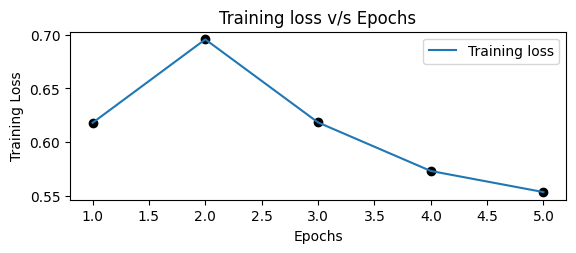

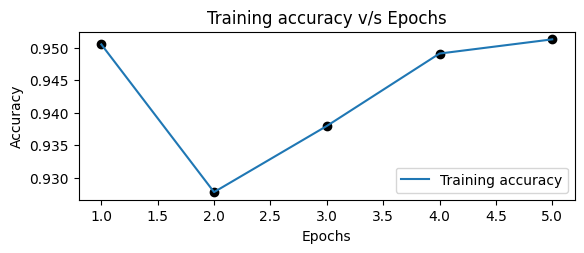

<Figure size 640x480 with 0 Axes>

In [111]:
import matplotlib.pyplot as plt

plt.subplot(2,1,1)
train_loss = hist_2.history['loss']
epochs = range(1,len(train_loss)+1)
plt.plot(epochs,train_loss,label="Training loss")
plt.scatter(epochs,train_loss,color="black")
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.title('Training loss v/s Epochs')
plt.legend()
plt.show()


plt.subplot(2,1,2)
train_acc = hist_2.history['accuracy']
epochs = range(1,len(train_acc)+1)
plt.plot(epochs,train_acc,label="Training accuracy")
plt.scatter(epochs,train_acc,color="black")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training accuracy v/s Epochs')
plt.legend()
plt.show()

plt.subplots_adjust(top=7,right=2.5,bottom=5)

In [107]:
prediction_2 = model.evaluate(x_test,y_test,batch_size=8)

4/4 [==============================] - 5s 1s/step - loss: 0.6234 - accuracy: 0.9762


#### Test Results

In [109]:
print('Loss obtained after refinement:',round(prediction_2[0],2),'\nAccuracy obtained after refinement:',round(prediction_2[1],2))

Loss obtained after refinement: 0.62 
Accuracy obtained after refinement: 0.98
